# Data and Figures for Centrality Study

In [1]:
%pylab inline

import pandas as pd
import scipy.sparse as sp
from scipy.sparse import linalg
from collections import defaultdict
from plotting import PLOT_STYLE

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from eventgraphs import EventGraph

## Communicability

In [3]:
# Generate a synthetic dataset with a preferred node

np.random.seed(1)

events = []

N = 20
M = 1000
t = 0 
nodes = np.arange(N)

for ix in range(M):
    t = t+1
    u,v = np.random.choice(nodes, size=2, replace=False)
    events.append((u,v,t))
    
    # If u=0 we force a second immediate path.
    if u == 0:
        t = t+1
        w = v
        while w == v: 
            w = np.random.choice(nodes, size=1, replace=False)
        events.append((v,w,t))
        
events = pd.DataFrame(events, columns=['source', 'target', 'time']).astype(int)

In [6]:
EG = EventGraph.from_pandas_eventlist(events, graph_rules='pfg')

def path_finder(e1,e2):
    dt = e2.time - e1.time
    if e1.target == e2.source:
        return True, dt
    else:
        return False, dt
EG.event_graph_rules['event_processor'] = path_finder
EG.event_graph_rules['subsequential'] = False

EG.build(verbose=True)

In [10]:
def generate_node_event_matrix(eventgraph, kind='source'): # General method to be included in eventgraphs.
    """Creates a node and event incidence matrix, whether a node is a source or target in an event."""
    
    X = []
    Y = []
    for ix, row in eventgraph.events.iterrows():
        Y.append(ix)
        X.append(row[kind])
    data = np.ones_like(X)
    A = sp.coo_matrix((data, (X,Y)), shape=(eventgraph.N, eventgraph.M), dtype=int)
    return A.tocsc()

def generate_rankings(EG, alpha, beta):
    """Calculates the event communicability matrix and broadcast score for each node. """
    T = EG.D
    Im = np.ones(EG.M)
    I = sp.eye(EG.M, format='csc')
    X = generate_node_event_matrix(EG)
    Y = EG.generate_eg_matrix()
    Y.data = np.array([np.exp(-beta*x) for x in Y.data])
    
    M = alpha*linalg.inv(I - alpha*Y)
    e = M.dot(Im)
    b = X.dot(e)
    
    return pd.Series(b), pd.Series(e)

def percentage_difference(b, focus=0):
    """Calculates the percentage gain that the focus node has over or under the second best (or first best if under)."""
    ranks = b.sort_values(ascending=False)
    if ranks.index[0] == focus:
        return ((ranks.iloc[0] - ranks.iloc[1])/ranks.iloc[1])
    else:
        return ((ranks.loc[focus] - ranks.iloc[0])/ranks.iloc[0])

In [55]:
x = np.linspace(0.1,0.9,9)
y = np.linspace(0,1,11)

P = defaultdict(dict)
store = defaultdict(dict)

for alpha in x:
    for beta in y:
        print(alpha,beta, end='\r')
        b, e = generate_rankings(EG, alpha, beta)
        P[alpha][beta] = percentage_difference(b)
        store[alpha][beta] = (b,e)

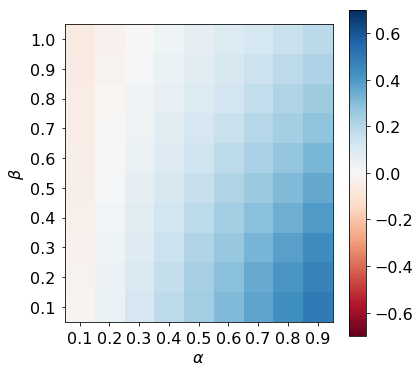

In [36]:
X = pd.DataFrame(P)

with plt.style.context(['seaborn-paper', PLOT_STYLE]):

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, aspect='equal')
    im = ax.imshow(X.values, vmin=-0.7, vmax=0.7, cmap=cm.RdBu, origin=0)
    fig.colorbar(im)

    ax.set_xticks(np.linspace(0,8,9))
    ax.set_xticklabels(np.linspace(0.1,0.9,9));
    ax.set_xlabel(r'$\alpha$')

    ax.set_yticks(np.linspace(1,11,11))
    ax.set_yticklabels(np.linspace(0.1,1,10));
    ax.set_ylabel(r'$\beta$')
    ax.set_ylim(0.5,10.5)

    fig.savefig('./figures/communicability_parameters.eps', bbox_inches='tight')

In [38]:
X = generate_node_event_matrix(EG)

examples = defaultdict(dict)

for alpha, beta in [(0.8, 0.30000000000000004),(0.2, 0.8)]:
    
    b, e = store[alpha][beta]
    cent = e[X[0].nonzero()[1]]
    special_node = cent.value_counts(normalize=False).sort_index().cumsum()
    
    if P[alpha][beta] > 0:
        node = b.nlargest().index[1]
    else:
        node = b.nlargest().index[0]

    cent = e[X[node].nonzero()[1]]
    other_node = cent.value_counts(normalize=False).sort_index().cumsum()

    examples[(alpha,beta)]['special'] = special_node
    examples[(alpha,beta)]['other'] = other_node    

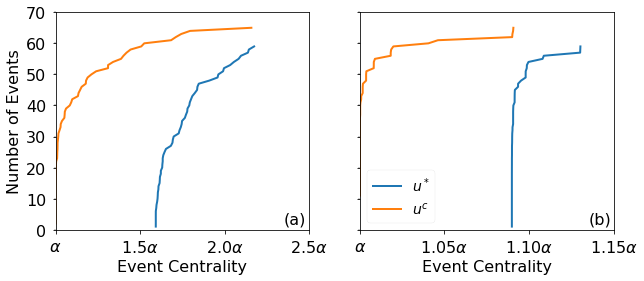

In [54]:
with plt.style.context(['seaborn-paper', PLOT_STYLE]):
    
    fig, (ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=(10,4))

    for ((alpha,beta), centralities), axis in zip(examples.items(), [ax1,ax2]):
    
        centralities['special'].plot(logx=False, logy=False, ax=axis, label='$u^*$')
        centralities['other'].plot(logx=False, logy=False, ax=axis, label='$u^c$')
        
        axis.set_ylabel("Number of Events")
        axis.set_xlabel("Event Centrality")
        
        axis.set_ylim(0,70)
            
        if axis==ax1:
            axis.set_xticks([alpha, 1.5*alpha, 2*alpha, 2.5*alpha])
            axis.set_xticklabels([r"$\alpha$", r"$1.5 \alpha$", r"$2.0 \alpha$", r"$2.5 \alpha$"])
            axis.text(0.9,0.03, s='(a)', transform=axis.transAxes)
        else:
            axis.set_xticks([alpha, 1.05*alpha, 1.10*alpha, 1.15*alpha])
            axis.set_xticklabels([r"$\alpha$", r"$1.05 \alpha$", r"$1.10\alpha$",r"$1.15\alpha$"])
            axis.text(0.9,0.03, s='(b)', transform=axis.transAxes)
        
        if axis==ax2:
            axis.legend(loc='best', fontsize=14)
            
    fig.savefig('./figures/communicability_event_distributions.eps', bbox_inches='tight')